## Grundliegende Analyse der Daten

In [ ]:
import pandas as pd

def read_csv_file(file_path):
    """
    Reads a CSV file and returns a DataFrame.
    
    :param file_path: Path to the CSV file.
    :return: DataFrame containing the data from the CSV file.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"Error reading the CSV file: {e}")
        return None

df = pd.read_excel('daten_zur_stammdatenpruefung.xlsx', skiprows=2)

distinct_count = df['Material-Bezeichnung'].nunique()
distinct_countries_listed = df['Land'].unique().tolist()
print(distinct_countries_listed)
print(distinct_count)

['DE', 'CZ', 'AT', 'IT', 'PL', 'RO', 'ES', 'NL', 'SE', 'FR', 'FI', 'CH', 'BG', 'HU', 'SK', 'BE', 'GB', 'SI', 'TR', 'RS', 'PT', 'XS', 'MA', 'CN', 'IE', 'TH', 'LT', 'LU']
3430


## Suchen nach gleichen einträgen welche unterschideliche GG-Einträge haben

In [ ]:
import pandas as pd

key_cols = ['ID-Nummer', 'Material-Bezeichnung']
df['art_present'] = df['Art_IdentNr'].notnull()
grouped = df.groupby(key_cols)['art_present'].agg(total_present='sum', total_rows='count')
grouped['missing_count'] = grouped['total_rows'] - grouped['total_present']
inconsistent_groups = grouped[(grouped['total_present'] > 0) & (grouped['missing_count'] > 0)].reset_index()
rows_to_review = df.merge(inconsistent_groups[key_cols], on=key_cols, how='inner')

In [2]:
analysis_df = df.copy()
ml_df = df.copy()

In [ ]:
import pandas as pd

# define what “no value” means in col1 and “has any value” in col2
missing_col1 = df['Art_IdentNr'].isna()
present_col2 = df['Klasse'].notna()

# 1) absolute count
count = (missing_col1 & present_col2).sum()
print(f"Number of rows where col1 is missing but col2 has a value: {count}")

# 2) as a fraction of all rows
frac_all = count / len(df)
print(f"That is {frac_all:.2%} of all rows")

# 3) as a fraction of rows with col1 missing
total_missing_col1 = missing_col1.sum()
if total_missing_col1:
    frac_missing = count / total_missing_col1
    print(f"That’s {frac_missing:.2%} of the rows where col1 is missing")
else:
    print("There are no rows where col1 is missing.")

# 4) inspect the offending rows if you like
bad_rows = df[missing_col1 & present_col2]
print(bad_rows.head())

## Verwenden von einem ML Verfahren um outlier zu finden

RandomRegressionCLassifier wird traniert mit Art_IdentNr als Label. Mit diesem modell wird dann anhand von den Test daten ein Potenzieller Treshold berechnet. Dieser wird dann verwendet um im Datensatz entries mit einer relativ höhen wahrscheinlichkeit als True klassifiziert zu werden, für human review zu markieren.

### Pre-Processing der Datenfelder

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.feature_selection import mutual_info_classif


## Definieren der Spalten die entfernt werden, hier: Identifikatoren, 1-1 korrelierende felder zu userem Label
columns_to_drop = ['ID-Nummer', 'MaterialNrNorm', 'Art_IdentNr', 'IdentNr', 'Klasse']

## Definition der Labels: Binäre Klassifikation, ob Art_IdentNr vorhanden ist
y = ml_df['Art_IdentNr'].notnull().astype(int)

## Entfernen der Identifikatoren sovie labels aus der Feature-Matrix
feature_cols = [c for c in ml_df.columns 
                if c not in columns_to_drop]
## Füllen der Nan Werte
X = ml_df[feature_cols].fillna('<<MISSING>>').astype(str)

# Encoding der Features
X_enc = X.apply(lambda col: LabelEncoder().fit_transform(col))

## Splaten namen werden zu Strings kovertiert
X_enc.columns = X_enc.columns.astype(str)

### Plot: mutual inforamtion

Top 10 features by mutual information:
 GG_Vorschrift See       0.089263
Verp.Methode Luft       0.088442
Material-Bezeichnung    0.088368
Verp.Methode See        0.086416
Lieferanten-Nr          0.081151
Name1                   0.080305
LT-Nr in                0.080180
LT-Nr out               0.079348
GG_Vorschrift Luft      0.077766
LT out Bezeichnung      0.076839
Volumen                 0.072642
Teile-Gewicht kg        0.071109
LT_1_BruttoGew_in_kg    0.069045
202512.2                0.058646
Breite                  0.057232
202507.2                0.055996
202506.2                0.055322
202510.2                0.054777
202508.2                0.054324
202505.2                0.054324
dtype: float64


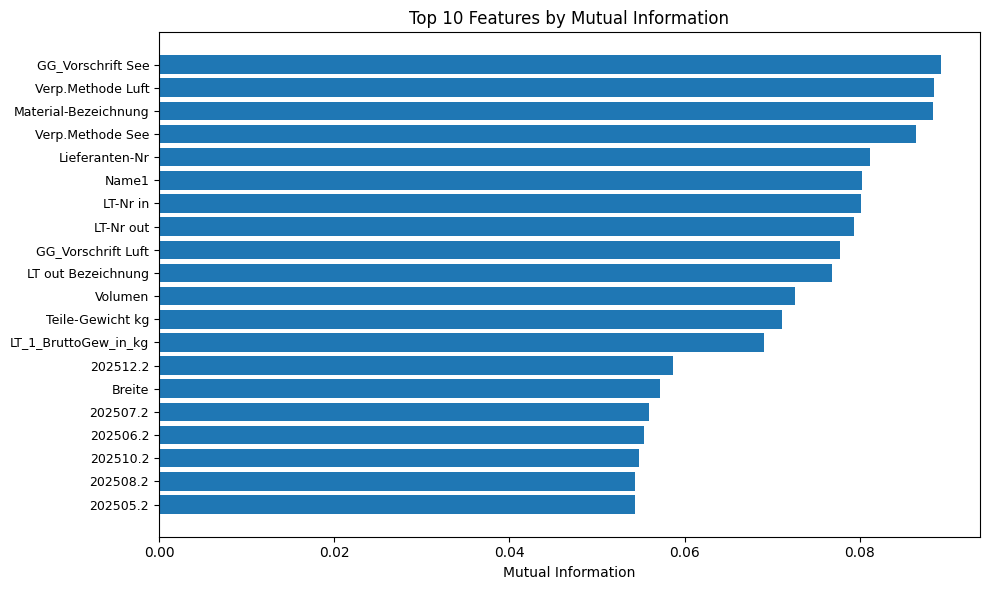

In [4]:
## Mutual Information Computation: Features -> Label
mi = mutual_info_classif(X_enc, y, discrete_features=True, random_state=0)
mi_series = pd.Series(mi, index=feature_cols).sort_values(ascending=False)
print(f"Top 10 features by mutual information:\n {mi_series.head(20)}")

## Visualisierung der Feature Importance
# Take the top 10 features from each Series
mi_top10  = mi_series.head(20)

# Set up a side-by-side bar plot
fig, axes = plt.subplots(figsize=(10, 6))

# Mutual Information
axes.barh(mi_top10.index[::-1], mi_top10.values[::-1])
axes.set_title("Top 10 Features by Mutual Information")
axes.set_xlabel("Mutual Information")
axes.tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()

### Plot: Cramer V (Spezifisch auf Klassen-spezifische Datenfelder)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def cramers_v(x: pd.Series, y: pd.Series) -> float:
    """
    Compute Cramér's V statistic for categorical–categorical association.
    Returns a value between 0 (no association) and 1 (perfect association).
    """
    # Build the contingency table
    confusion = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion)
    n = confusion.values.sum()
    phi2 = chi2 / n

    # Bias correction
    r, k = confusion.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    r_corr = r - ((r-1)**2) / (n-1)
    k_corr = k - ((k-1)**2) / (n-1)

    return np.sqrt(phi2_corr / min(k_corr-1, r_corr-1))


v = cramers_v(X_enc['Material-Bezeichnung'], y)
print(f"Cramér's V = {v:.3f}")



### Theils U Chart

In [ ]:
import numpy as np
import pandas as pd

def conditional_entropy(x: pd.Series, y: pd.Series) -> float:
    """
    H(X|Y) = sum_y p(y) * H(X | Y=y)
    """
    total = len(x)
    # counts of each y
    y_counts = y.value_counts()
    # joint counts
    joint = pd.crosstab(x, y)

    ce = 0.0
    for y_val, y_count in y_counts.items():
        p_y = y_count / total
        # distribution of X given Y=y_val
        x_counts = joint[y_val]
        probs = x_counts / y_count
        # entropy for this slice
        h_x_given_y = -np.sum([p * np.log2(p) for p in probs if p > 0])
        ce += p_y * h_x_given_y
    return ce

def theils_u(x: pd.Series, y: pd.Series) -> float:
    """
    Theil's U = (H(X) - H(X|Y)) / H(X)
    Asymmetric: U(X|Y) != U(Y|X)
    """
    # marginal entropy H(X)
    p_x = x.value_counts() / len(x)
    h_x = -np.sum(p_x * np.log2(p_x))

    if h_x == 0:
        return 1.0  # no uncertainty in X at all

    h_x_given_y = conditional_entropy(x, y)
    return (h_x - h_x_given_y) / h_x


# Example usage:
#u_xy = theils_u(df['feature_x'], df['feature_y'])
#u_yx = theils_u(df['feature_y'], df['feature_x'])
#print(f"Theil's U (X|Y) = {u_xy:.3f}")
# print(f"Theil's U (Y|X) = {u_yx:.3f}")


### Plots: Correlation / Pearson-R Chart

In [ ]:
import matplotlib.pyplot as plt

## Pearson-R Correaltion mit Label
corr_with_label = X_enc.apply(lambda col: col.corr(y, method='pearson'))
corr_with_label = corr_with_label.reindex(corr_with_label.abs().sort_values(ascending=False).index)
corr_df = pd.DataFrame({
    'feature': corr_with_label.index,
    'corr_with_label': corr_with_label.values
})
print(corr_df)

## Chart der Korrelationen
plt.figure(figsize=(12, 10))
corr_with_label.head(50).plot.bar()
plt.ylabel('Pearson r')
plt.title('Feature correlation with label')
plt.tight_layout()
plt.show()


### RandomRegressionClassifier

Using threshold = 0.020 for ≥ 80% precision


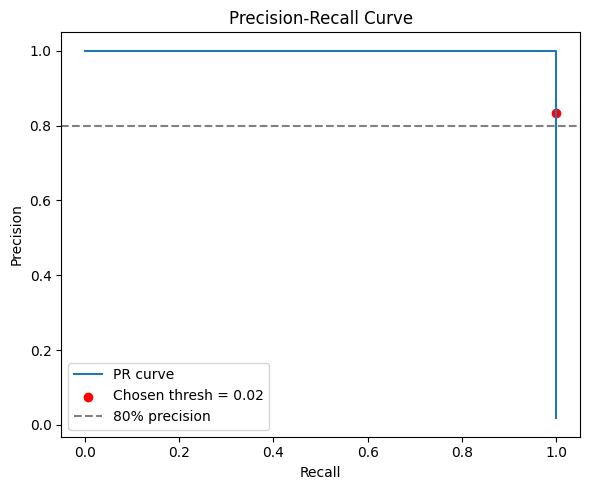

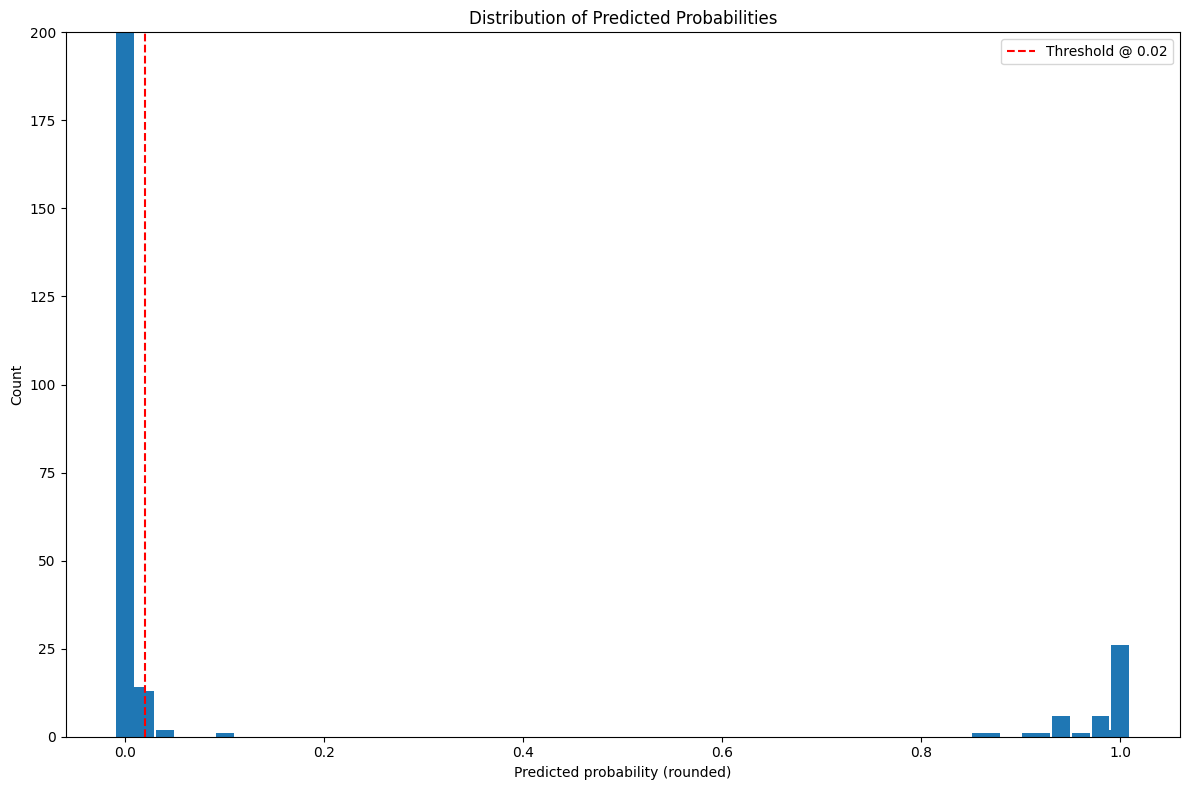

In [5]:
## Train-Test-Split
X_train, X_val, y_train, y_val = train_test_split(
    X_enc, y, stratify=y, test_size=0.2, random_state=42)

## RandomForest-Klassifikator trainieren
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

## Predict probabilites werden auf die X_val Daten angewendet
probs = rf.predict_proba(X_val)[:,1]

## Treshold berechnen aus der precision-recall-Kurve
prec, rec, thresh = precision_recall_curve(y_val, probs)

## Bestimmung des Tresholds für eine gewünschte Präzision
target_prec = 0.80
#candidates = np.where(prec >= target_prec)[0]
candidates = np.where(prec[1:] >= target_prec)[0]
if len(candidates):
    chosen_idx = candidates[0]
    chosen_thresh = thresh[chosen_idx]
    print(f"Using threshold = {chosen_thresh:.3f} for ≥ {target_prec*100:.0f}% precision")
else:
    chosen_thresh = 0.5
    print("Couldn't find 90% precision; defaulting to 0.5")

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label='PR curve')
plt.scatter(rec[chosen_idx+1], prec[chosen_idx+1], 
            color='red', 
            label=f'Chosen thresh = {chosen_thresh:.2f}')
plt.axhline(target_prec, color='grey', linestyle='--',
            label=f'{target_prec*100:.0f}% precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# --- Plot 2: Histogram of Predicted Probabilities ---
# Round probabilities to two decimals (or whatever makes sense)
rounded_probs = np.round(probs, 2)
# Count occurrences
unique_vals, counts = np.unique(rounded_probs, return_counts=True)

plt.figure(figsize=(12,8))
plt.bar(unique_vals, counts, width=0.018)
plt.axvline(chosen_thresh, color='red', linestyle='--',
            label=f'Threshold @ {chosen_thresh:.2f}')
plt.ylim(0, 200)
plt.xlabel('Predicted probability (rounded)')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.tight_layout()
plt.show()


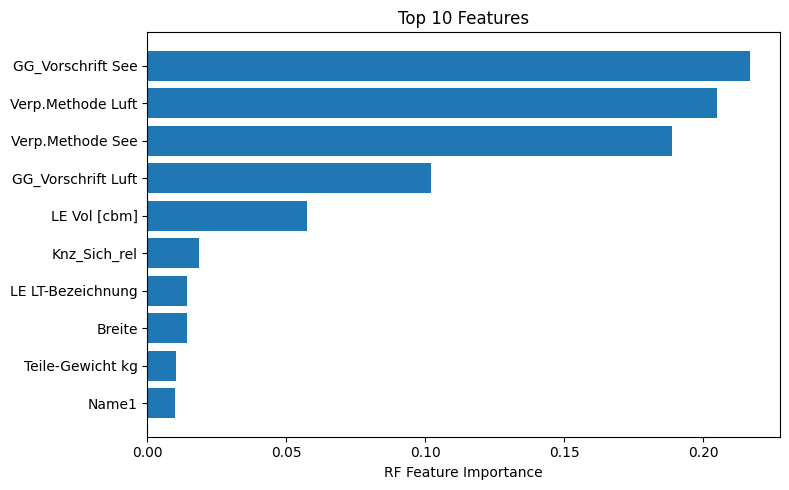

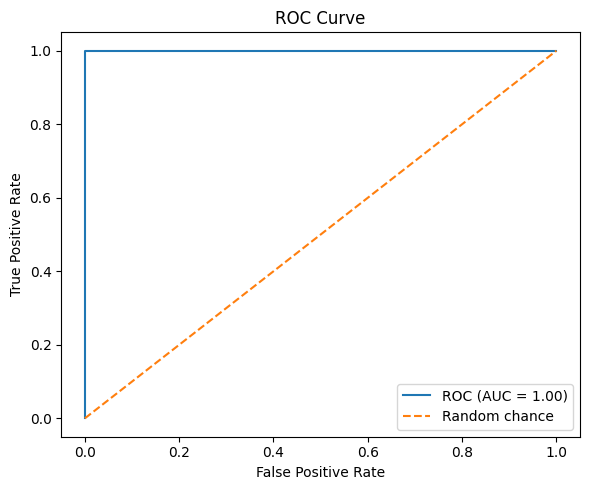

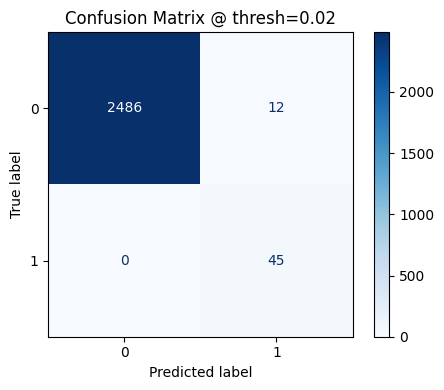

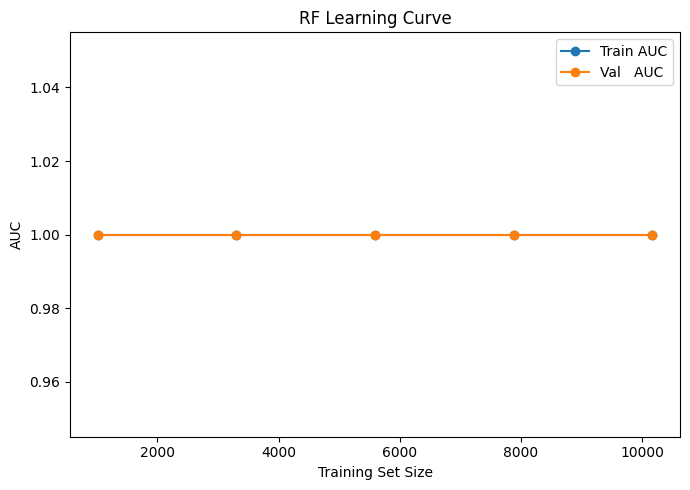

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import learning_curve

# --- 1) Feature Importances Bar Chart ---
importances = rf.feature_importances_
feat_names  = X_enc.columns
indices     = np.argsort(importances)[::-1]

top_n = 10
plt.figure(figsize=(8,5))
plt.barh(
    feat_names[indices][:top_n][::-1],
    importances[indices][:top_n][::-1]
)
plt.xlabel("RF Feature Importance")
plt.title(f"Top {top_n} Features")
plt.tight_layout()
plt.show()


# --- 2) ROC Curve & AUC ---
fpr, tpr, roc_thresh = roc_curve(y_val, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', label='Random chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# --- 3) Confusion Matrix (at your chosen threshold) ---
#  use your `chosen_thresh` from before:
y_pred_thresh = (probs >= chosen_thresh).astype(int)
cm = confusion_matrix(y_val, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
plt.figure(figsize=(5,4))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title(f'Confusion Matrix @ thresh={chosen_thresh:.2f}')
plt.tight_layout()
plt.show()


# --- 4) Learning Curve (train vs. validation score) ---
train_sizes, train_scores, val_scores = learning_curve(
    rf, X_enc, y,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    scoring='roc_auc'       # or 'accuracy', 'precision', etc.
)

train_mean = np.mean(train_scores, axis=1)
val_mean   = np.mean(val_scores,   axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', label='Train AUC')
plt.plot(train_sizes, val_mean,   'o-', label='Val   AUC')
plt.xlabel("Training Set Size")
plt.ylabel("AUC")
plt.title("RF Learning Curve")
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### Extrahieren und speichern der Tabelle

In [15]:
## Extrahieren der Rows welche mit dem gewählten Treshold markiert wurden
all_probs = rf.predict_proba(X_enc)[:,1]
ml_df['pred_prob_art'] = all_probs
ml_df['flag_missing_art'] = (
    ml_df['Art_IdentNr'].isnull() & (ml_df['pred_prob_art'] >= chosen_thresh)
)

## Speichern in Datei
flags = ml_df[ml_df['flag_missing_art']]
flags.to_csv('flagged_missing_adr_more_dropped.csv', index=False)

##
presentation_cols = [
    'ID-Nummer', 'Material-Bezeichnung',
    'pred_prob_art'
]
flags_presentation = flags[presentation_cols]
# Sort by 'pred_prob_art' for easier review
flags_presentation = flags_presentation.sort_values(by='pred_prob_art', ascending=False)
flags_presentation.to_csv('flagged_missing_adr_more_dropped_presentation.csv', index=False)

print(f"Flagged {len(flags)} rows out of {len(ml_df)} for human review.")

Flagged 27 rows out of 12712 for human review.


## Analyse der ML Vorhersage

/Users/agres/Projects/seb/erp_systeme/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


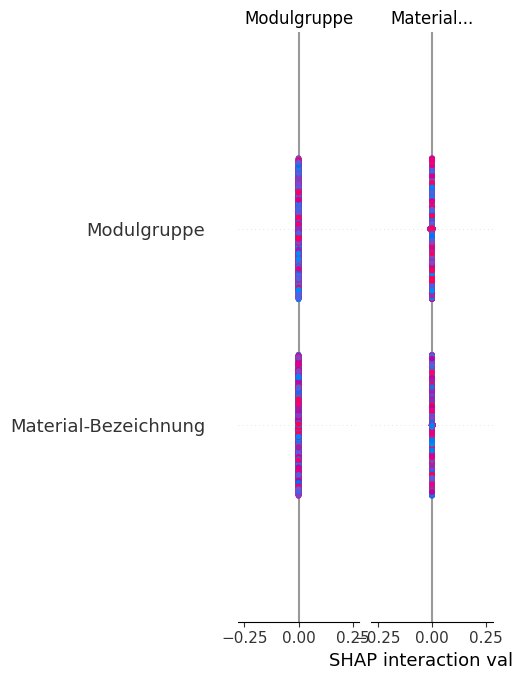

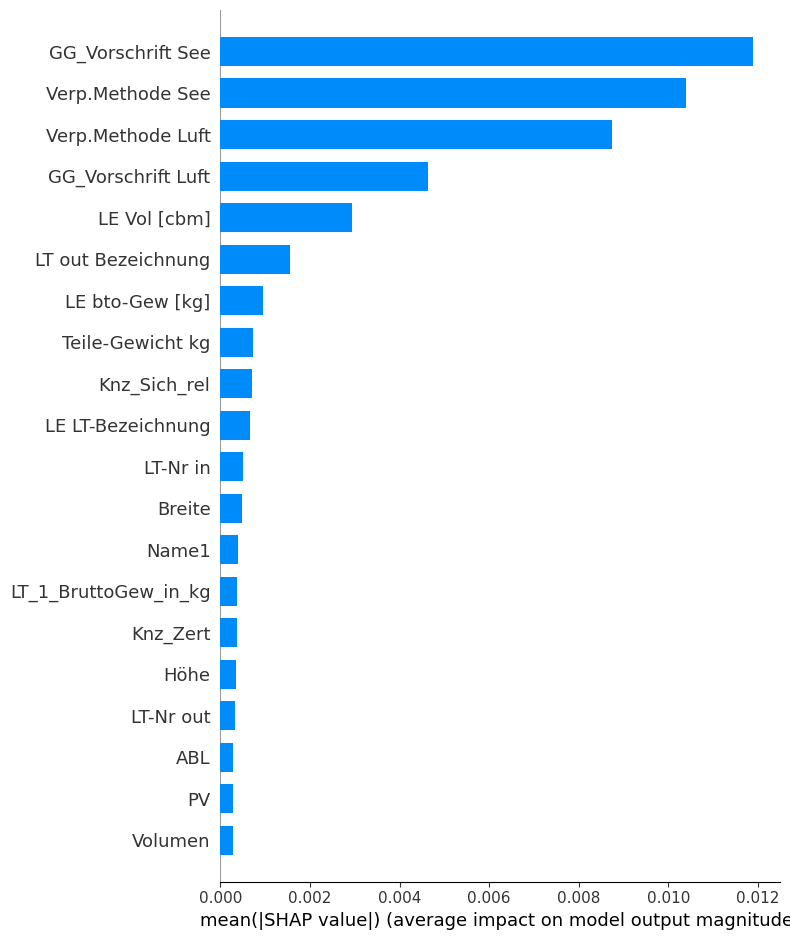

In [10]:
import shap
import matplotlib.pyplot as plt

# 1) Init the new Explainer
explainer = shap.Explainer(rf, X_train, feature_names=X_train.columns)

# 2) Compute SHAP values
#    This returns an Explanation object
shap_exp = explainer(X_val)

# 3) Directly plot summary
#    No need to pick indices or slice — it knows you have two output classes
shap.summary_plot(shap_exp)

# 4) If you just want the positive‐class contribution:
#    shap_exp[...,1] is the Explanation for class 1
shap.summary_plot(shap_exp[...,1], X_val, plot_type="bar")


Sample 41 has P(1) = 1.000


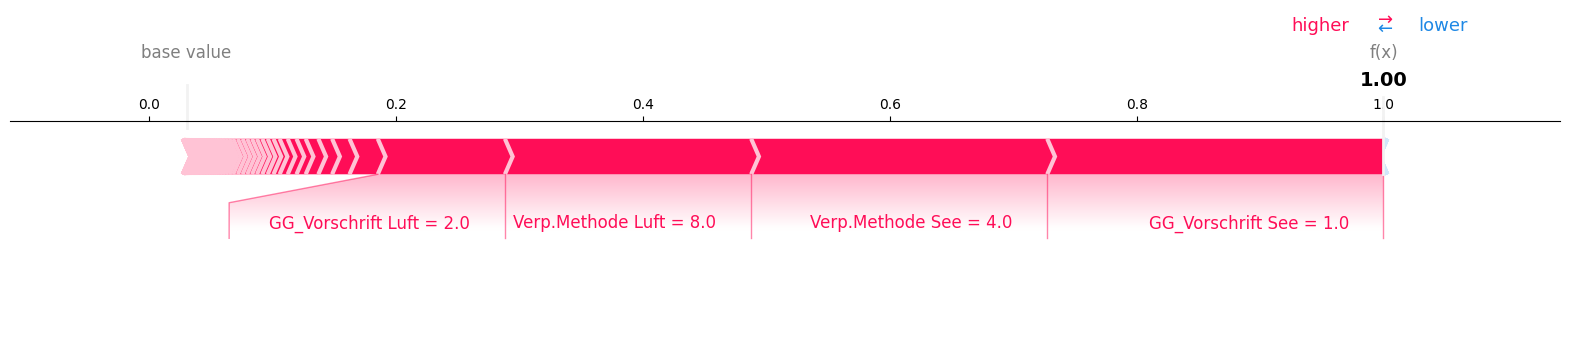

<Figure size 640x480 with 0 Axes>

In [11]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 1) Fit your explainer on the training set
explainer = shap.Explainer(rf, X_train, feature_names=X_train.columns)

# 2) Compute SHAP values on your validation (or test) set
shap_exp = explainer(X_val)

# 3) Pick the record with the highest P(1)
probas = rf.predict_proba(X_val)[:, 1]
i = np.argmax(probas)
print(f"Sample {i} has P(1) = {probas[i]:.3f}")

# 4) Grab the base value & SHAP contributions for class “1”
base_value    = explainer.expected_value[1]
shap_vals_cls = shap_exp.values[i][:, 1]
feature_vals  = X_val.iloc[i]

# 5) Plot it via matplotlib
shap.force_plot(
    base_value,        # <-- must be first!
    shap_vals_cls,     # <-- your per-feature contributions
    feature_vals,      # <-- the actual feature values
    feature_names=X_val.columns,
    matplotlib=True
)
plt.tight_layout()
plt.show()


Sample 41 has P(1) = 1.000
Plotting 127 features with |SHAP| ≤ 0.1


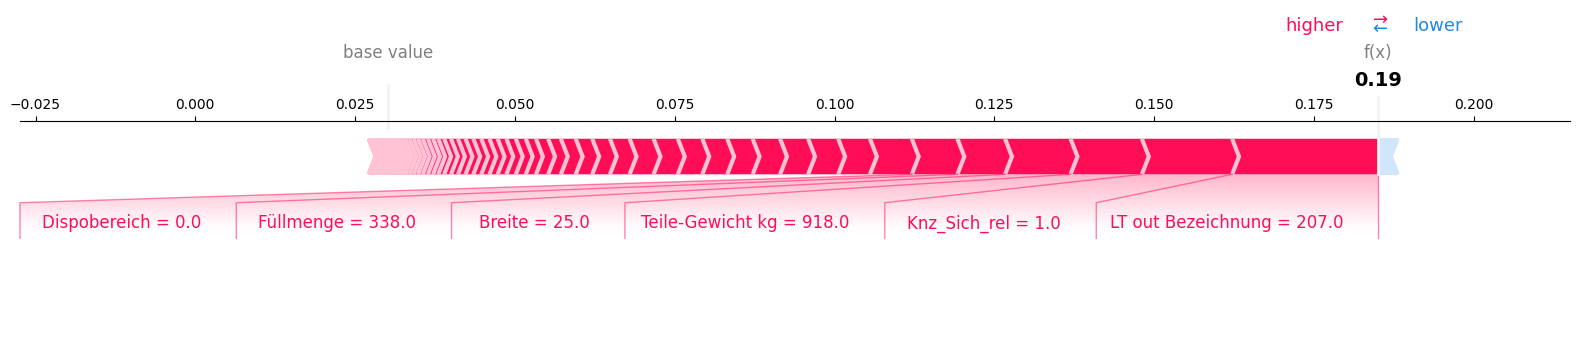

In [12]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 1) Fit your explainer on the training set
explainer = shap.Explainer(rf, X_train, feature_names=X_train.columns)

# 2) Compute SHAP values on your validation (or test) set
shap_exp = explainer(X_val)

# 3) Pick the record with the highest P(1)
probas = rf.predict_proba(X_val)[:, 1]
i = np.argmax(probas)
print(f"Sample {i} has P(1) = {probas[i]:.3f}")

# 4) Grab the base value & SHAP contributions for class “1”
base_value    = explainer.expected_value[1]
shap_vals_cls = shap_exp.values[i][:, 1]
feature_vals  = X_val.iloc[i]

# turn the SHAP array into a Series so it lines up with feature_vals
shap_s = pd.Series(shap_vals_cls, index=X_val.columns)

# choose your cutoff (absolute SHAP value)
cutoff = 0.10

# keep only “small” contributions
keep = shap_s.abs() <= cutoff
shap_s_small   = shap_s[keep]
feat_vals_small = feature_vals[keep.index][keep]  # align the same mask

print(f"Plotting {len(shap_s_small)} features with |SHAP| ≤ {cutoff}")

# 1) old API
shap.force_plot(
    base_value,
    shap_s_small.values,
    feat_vals_small.values,
    feature_names=list(feat_vals_small.index),
    matplotlib=True
)
plt.show()
